# Risk of early stopped gradient descent


In [3]:
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pyplot as plt
from numpy import *
import numpy as np

In [5]:
def risk(thetas,sigmas,stepsize,k,sigma_noise,n):
    out =  sigmas**2*(1-stepsize*sigmas**2)**(2*k) @ thetas**2
    out += np.sum( (sigma_noise**2/n)*(1-(1-stepsize*sigmas**2)**k)**2 )
    out += sigma_noise**2
    return out

def res_to_mtx(losses,filename):
    ks = [i for i in range(len(losses[0]))]
    A = [np.array(ks)]
    A += losses
    A = np.vstack( A ).T
    print(A.shape)
    np.savetxt(filename, A, delimiter=' ')

def savemtx_for_logplot(A,filename = "exp.dat"):
    ind = sorted(list(set([int(i) for i in np.geomspace(1, len(A[0])-1 ,num=700)])))
    A = [ [a[i] for i in ind]  for a in A]
    X = np.array([ind] + A)
    np.savetxt(filename, X.T, delimiter=' ')

### Linear model
The linear model generates sampels as

$$
y = \langle x,\beta \rangle + z,
$$

where $x \in \mathbb R^d$ is zero-mean Gaussian with diagonal co-variance matrix $\mathrm{diag}(\sigma_1^2,\ldots,\sigma_n^2)$, and $z$ is zero-mean Gaussian with variance $\sigma^2$.

In [3]:
class linear_model():
    def __init__(self,d,sigma_noise=0,beta=None,sigmas=None):
        self.d = d
        if beta is None:
            self.beta = np.random.randn(self.d)
            #self.beta = np.ones(self.d)
        else:
            self.beta = beta
        
        self.sigma_noise = sigma_noise
        
        if sigmas is None:
            self.sigmas = np.ones(d)/np.sqrt(self.d)
        else:
            self.sigmas = sigmas
            
    def estimate_risk(self,estimator,avover=500):
        # estimator is an instance of a class with a predict function mapping x to a predicted y
        # function estimates the risk by averaging
        risk = 0
        for i in range(avover):
            x = np.random.randn(self.d) * self.sigmas 
            y = x @ self.beta + self.sigma_noise*np.random.randn(1)[0]
            risk += (y - estimator.predict(x))**2
        return risk/avover
    
    def compute_risk(self,hatbeta):
        # compute risk of a linear estimator based on formula
        return np.sum( np.array(self.sigmas)**2 * (self.beta-hatbeta)**2 ) + self.sigma_noise**2
    
    def sample(self,n):
        Xs = []
        ys = []
        for i in range(n):
            x = np.random.randn(self.d) * self.sigmas
            y = x @ self.beta + self.sigma_noise*np.random.randn(1)[0]
            Xs += [x]
            ys += [y]
        return np.array(Xs),np.array(ys)

In [4]:
class subset_regression():
    # perform regression based on a subset T of cardinality p of the variables {1,...,d}
    def __init__(self,p=0,d=0,T=None):
        if T is None:
            self.T = np.random.choice(d, p, replace=False) # sample without replacement p indices from {1,...,d}
        else:
            self.T = T
        self.p = p
        self.d = d
        #print("T is:",self.T)
        
    def predict(self,x):
        return x @ self.beta
    
    def train(self,Xs,ys):
        XT = Xs[:,self.T] # n x p matrix, p >= n
        betaT = np.linalg.pinv(XT) @ ys
        self.beta = np.zeros(self.d)
        self.beta[self.T] = betaT
        
    def train_with_gd(self,Xs,ys,nsteps,stepsize=None,every=None,decay_rate=True):
        # obtain betaT by minimizing:
        # ||XT beta - y||_2^2
        # with gradient descent
        XT = Xs[:,self.T] # n x p matrix, p >= n if overparameterized
        
        Q = XT.T @ XT #Q = np.dot(XT.T,XT)
        # compute optimal fixed stepsize
        eigenvalues = np.abs(linalg.eigvals(Q))
        
        #plt.plot(eigenvalues)
        #plt.show()
        
        if stepsize is None:
            M = max(eigenvalues)
            m = np.abs(min(eigenvalues))
            #stepsize = 2/(M+m)
            stepsize = 1.0/M
            #print("min/max svd of Q:", M, m)
        
        self.betas = []
        betaT = np.zeros(self.p) # start GD from zero
        #betaT = np.random.randn(self.p) # start GD from random initialization
        for i in range(nsteps):
            gradient = 0.5*( Q @ betaT - XT.T @ ys )
            if decay_rate:
                stepsize = 1/np.sqrt(1+i)/M
            
            betaT = betaT - stepsize*gradient
            
            if every is not None:
                if i % every == 0:
                    beta_tmp = np.zeros(self.d)
                    beta_tmp[self.T] = betaT
                    self.betas += [beta_tmp]
        
        self.beta = np.zeros(self.d)
        self.beta[self.T] = betaT
    
    def train_with_sgd(self,Xs,ys,nepochs,stepsize=None,every=None,decay_rate=True):
        # obtain betaT by minimizing:
        # ||XT beta - y||_2^2
        # with stochastic gradient descent
        XT = Xs[:,self.T] # n x p matrix, p >= n if overparameterized
        
        if stepsize==None:
            Q = XT.T @ XT #Q = np.dot(XT.T,XT)
            # compute optimal fixed stepsize
            eigenvalues = linalg.eigvals(Q)
            M = max(eigenvalues)
            stepsize = 1/M
            
        self.betas = []
        n = XT.shape[0]
        betaT = np.zeros(self.p)
        for i in range(n*nepochs):
            ind = np.random.choice(n,1)[0] # get random index
            gradient = (ys[ind] + XT[ind] @ betaT) * XT[ind]
            if decay_rate:
                stepsize = 1/np.sqrt(1+i/10)/M
                
            betaT = betaT - stepsize*gradient
            if every is not None:
                if i % every == 0:
                    beta_tmp = np.zeros(self.d)
                    beta_tmp[self.T] = betaT
                    self.betas += [beta_tmp]

In [5]:
def average_risk(thetas,sigmas,n,niterations = 10000,avover = 1, stepsize=None):
    d = len(thetas)
    p = d # we take all into account
    
    #stepsize = 1.0/(max(sigmas))
    allrisks = []
    alllosses = []
    for i in range(avover):
        model = linear_model(d,sigma_noise=1.0,beta=thetas,sigmas=sigmas)
        Xs,ys = model.sample(n)
    
        #print("n,d:", Xs.shape)
        estimator = subset_regression(p,d,T=[i for i in range(p)])
        estimator.train_with_gd(Xs,ys,niterations,every=1,stepsize=stepsize,decay_rate=False)
    
        risks = []
        losses = []
        for beta in estimator.betas:
            #estimator.beta = beta
            #risk = model.risk(estimator,avover=300)
            risk = model.compute_risk(beta)
            risks += [risk]
            loss = np.linalg.norm( Xs @ beta - ys )
            losses += [loss]
        alllosses += [losses]
        allrisks += [risks]
    avrisks = np.mean( np.array(allrisks),axis=0)
    avlosses = np.mean( np.array(alllosses),axis=0)
    return avrisks,avlosses

# Under-parameterized regime - Figure 5

## Configuration A

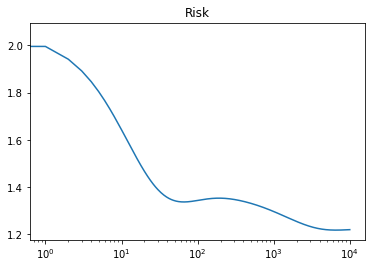

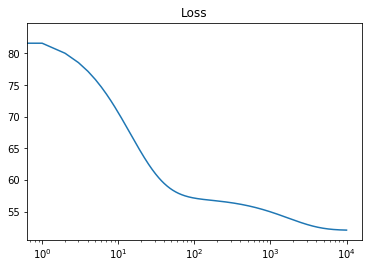

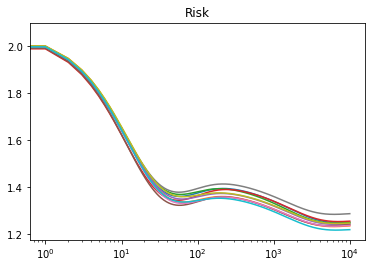

In [7]:
kmax = 10000
dm = 100
sigmas = np.array([1.0]*6*dm + [0.1]*dm)
thetas = np.array( [1.0]*6*dm + [10.0]*dm)*0.04

n = len(thetas)*5

stepsize = 0.00002

allavrisks = []
for i in range(10):
    avrisks,avlosses = average_risk(thetas,sigmas,n=n,niterations = 10000,avover = 1,stepsize=stepsize)
    allavrisks += [avrisks]
    
plt.xscale("log")
plt.plot(avrisks)
plt.title("Risk")
plt.show()

plt.xscale("log")
plt.plot(avlosses)
plt.title("Loss")
plt.show()

for avrisks in allavrisks:
    plt.plot(avrisks)
plt.xscale("log")
plt.title("Risk")
plt.show()

### Theoretical predition with empirical curve

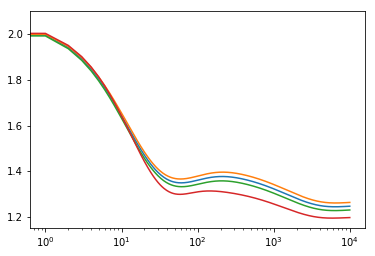

In [8]:
sigma_noise = 1.0
risks = np.array([risk(thetas,sigmas,len(thetas)*stepsize*2.3,k,sigma_noise,n) for k in range(1,kmax+1)])

plt.xscale('log')

mean = np.mean( allavrisks , axis=0 )
std  = np.std( allavrisks , axis=0 ) 

plt.plot( mean )
plt.plot( mean+std )
plt.plot( mean-std )

plt.plot( risks )
plt.show()

savemtx_for_logplot( np.array([risks,mean,std]),"risk_n=5d.dat" ) 

## Configuration B: larger n

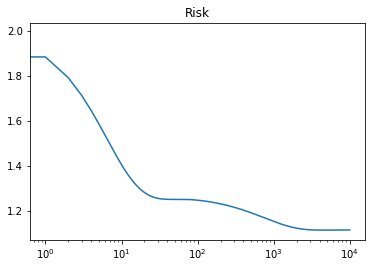

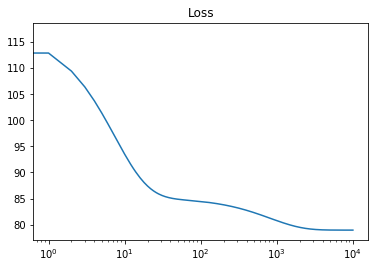

In [32]:
#dm = 100
#sigmas = np.array([1.0]*6*dm + [0.1]*dm)
#thetas = np.array( [1.0]*6*dm + [10.0]*dm)*0.04

n = len(thetas)*10

stepsize = 0.00002

allavrisksB = []
for i in range(10):
    avrisks,avlosses = average_risk(thetas,sigmas,n=n,niterations = 10000,avover = 1,stepsize=stepsize)
    allavrisksB += [avrisks]
    
plt.xscale("log")
plt.plot(avrisks)
plt.title("Risk")
plt.show()

plt.xscale("log")
plt.plot(avlosses)
plt.title("Loss")
plt.show()

### Theoretical predition with empirical curve

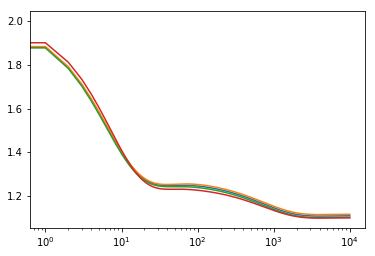

In [33]:
sigma_noise = 1.0
risksB = np.array([risk(thetas,sigmas,len(thetas)*stepsize*4.5,k,sigma_noise,n) for k in range(1,kmax+1)])

plt.xscale('log')

mean = np.mean( allavrisksB , axis=0 )
std  = np.std( allavrisksB , axis=0 ) 

plt.plot( mean )
plt.plot( mean+std )
plt.plot( mean-std )

plt.plot( risksB )

plt.show()

savemtx_for_logplot( np.array([risksB,mean,std]),"risk_n=10d.dat" ) 

# Overparameterized regime - additional results

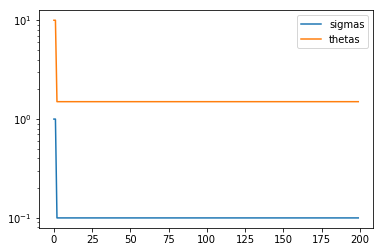

Signal variance: 204.45499999999987


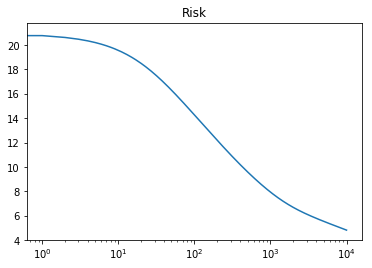

In [83]:
def expected_risk(thetas,sigmas,n,stepsize,numsteps,avover=100):
    d = len(thetas)
    avrisks = np.zeros(numsteps)
    for i in range(avover):
        X = np.random.randn(n,d) @ np.diag(sigmas)
        Q = np.eye(d) - stepsize/n * X.T @ X
        Qk = Q*1.0
        risks = []
        for k in range(numsteps):
            risks += [np.linalg.norm( Qk @ thetas)]
            Qk = Qk @ Q
            
        avrisks += np.array(risks)/avover
    return avrisks

d = 200
q = 2
n = 2*int(d/2)
sigmas = [1.0]*q + [0.1]*(d-q)
thetas = [10.0]*q + [1.5]*(d-q)

plt.plot(sigmas,label="sigmas")
plt.plot(thetas,label="thetas")
plt.legend()
plt.yscale('log')
plt.show()

print("Signal variance:",sum([sig**2*th**2 for sig,th in zip(sigmas,thetas)]))

stepsize = 0.9
avrisks = expected_risk(thetas,sigmas,n,stepsize,10000,avover=1)

plt.xscale('log')
plt.plot(avrisks)
plt.title("Risk")
plt.show()

### Large problem, no averaging

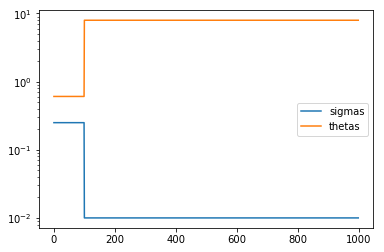

Signal variance: 8.00301220285408


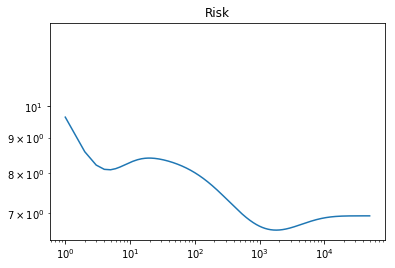

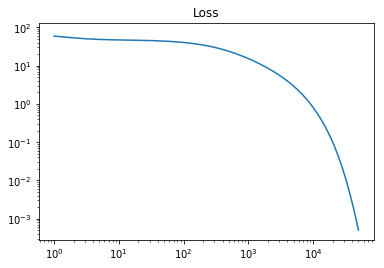

In [608]:
d = 1000
p, q = 0,100
sigmas = [1]*p + [0.25]*q + [0.01]*(d-p-q)
thetas = [0.2/sig**0.80 for sig in sigmas]

plt.plot(sigmas,label="sigmas")
plt.plot(thetas,label="thetas")
plt.legend()
plt.yscale('log')
plt.show()

print("Signal variance:",sum([sig**2*th**2 for sig,th in zip(sigmas,thetas)]))

avrisks,avlosses = average_risk(thetas,sigmas,n=int(0.5*d),niterations = 100000,avover = 1)

plt.loglog(avrisks)
plt.title("Risk")
plt.show()

plt.loglog(avlosses)
plt.title("Loss")
plt.show()

### Large problem, no averaging, no noise

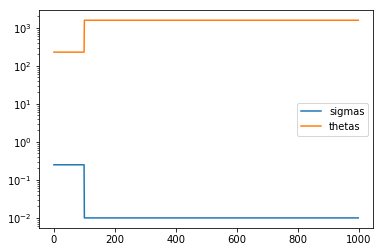

Signal variance: 558172.767342228


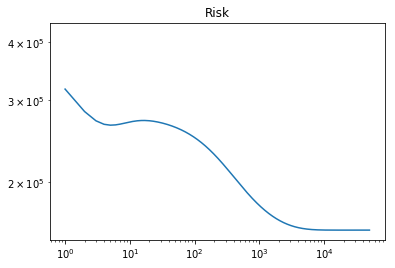

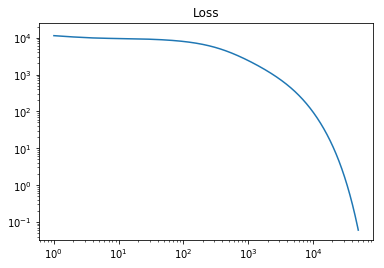

In [463]:
d = 1000
p, q = 0,100
sigmas = [1]*p + [0.25]*q + [0.01]*(d-p-q)
thetas = [100.2/sig**0.60 for sig in sigmas]

plt.plot(sigmas,label="sigmas")
plt.plot(thetas,label="thetas")
plt.legend()
plt.yscale('log')
plt.show()

print("Signal variance:",sum([sig**2*th**2 for sig,th in zip(sigmas,thetas)]))

avrisks,avlosses = average_risk(thetas,sigmas,n=int(0.5*d),niterations = 100000,avover = 1)

plt.loglog(avrisks)
plt.title("Risk")
plt.show()

plt.loglog(avlosses)
plt.title("Loss")
plt.show()